In [1]:
# Cell 1: Setup - Import Libraries and Load Data
# Purpose: Import all required libraries for data handling, modeling, and visualization.
# Note: If running for the first time, uncomment and run the pip install commands below.

# Standard data handling and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Advanced modeling libraries
# Uncomment if not already installed:
# !pip install xgboost
# !pip install tensorflow
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# --- Load the dataset ---
# Assumes 'data.csv' is in the same directory.
try:
    data = pd.read_csv('data.csv')
    # Clean column names by stripping whitespace
    data.columns = data.columns.str.strip()
    print("✅ File 'data.csv' loaded successfully!")
    print("\nFirst 5 rows of the dataset:")
    print(data.head())
except FileNotFoundError:
    print("❌ Error: 'data.csv' not found. Please ensure the file is in the current directory.")
    
    # === NEW: RAW DATA VISUALIZATION ===
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x='Avg_Reaction_Time', y='Accuracy', alpha=0.8, s=80)
    plt.title("Raw Data Distribution")
    plt.grid(True)
    plt.savefig('Data_Visualize.jpg', dpi=300) 
    plt.show()
    
    print("Data loaded successfully! First 5 rows:")
    print(data.head())
except FileNotFoundError:
    print("Error: File not found")
    exit()

g:\code test\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
g:\code test\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
g:\code test\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime re

✅ File 'data.csv' loaded successfully!

First 5 rows of the dataset:
   Accuracy  Avg_Reaction_Time
0      89.0               2.20
1      83.0               1.89
2      90.0               1.28
3      93.0               2.00
4      84.0               1.30



STEP 1: MANUAL LABELING OF DATA

📊 Distribution of Manually Assigned Labels:
manual_label
Needs Improvement    7
Good Performer       6
Careful Performer    3
Name: count, dtype: int64

🖼️  Plotting label distribution...


C:\Users\Iftikher\AppData\Local\Temp\ipykernel_21232\672974349.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", edgecolor='black')


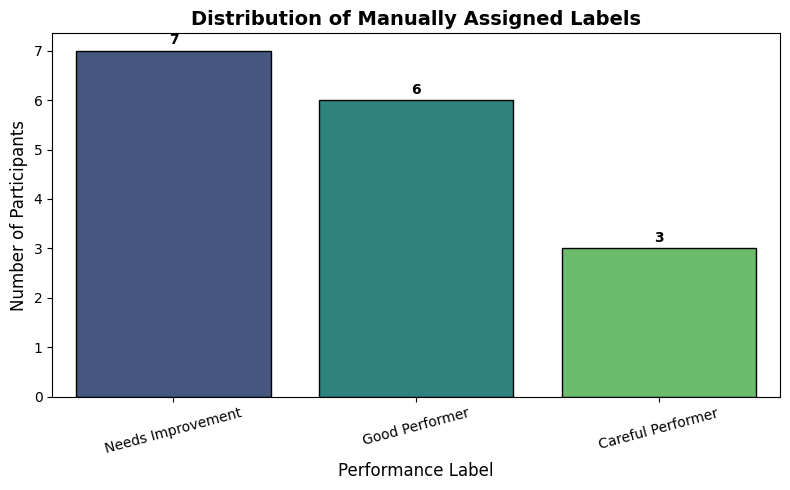


✅ Manual labeling completed. All classes have sufficient samples for modeling.


In [ ]:
# Cell 2: Manual Labeling with Visualization
# Purpose: Assign meaningful labels based on domain logic and visualize their distribution.
# Strategy:
#   - 'Careful Performer': High accuracy but slow (>=2.5s) → cautious behavior
#   - 'Needs Improvement': Low accuracy (<90%) → inconsistent or rushed
#   - 'Good Performer': Others (likely balanced speed and accuracy)

print("\n" + "="*60)
print("STEP 1: MANUAL LABELING OF DATA")
print("="*60)

# Define conditions for labeling
conditions = [
    (data['Accuracy'] >= 90) & (data['Avg_Reaction_Time'] >= 2.5),  # Accurate but slow
    (data['Accuracy'] < 90)                                        # Inaccurate (needs work)
]

# Corresponding labels for each condition
choices = [
    'Careful Performer',
    'Needs Improvement'
]

# Apply labeling: Default is 'Good Performer' for remaining cases
data['manual_label'] = np.select(conditions, choices, default='Good Performer')

# Display label distribution
print("\n📊 Distribution of Manually Assigned Labels:")
label_counts = data['manual_label'].value_counts()
print(label_counts)

# --- New: Create a bar plot for label distribution ---
print("\n🖼️  Plotting label distribution...")

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", edgecolor='black')

# Add title and labels
plt.title("Distribution of Manually Assigned Labels", fontsize=14, fontweight='bold')
plt.xlabel("Performance Label", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)

# Rotate x-axis labels if needed
plt.xticks(rotation=15)

# Add value labels on top of each bar
for index, value in enumerate(label_counts.values):
    plt.text(index, value + max(label_counts.values)*0.01, str(value), 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.savefig('Label_Distribution.jpg', dpi=300)  

# Show the plot
plt.show()

# Confirm success
print("\n✅ Manual labeling completed. All classes have sufficient samples for modeling.")

In [3]:
# Cell 3: Feature Engineering
# Purpose: Create new statistical features to enhance model performance.
# New Features:
#   - Speed_Score: Inverse of reaction time (higher = faster)
#   - Performance_Ratio: Combines accuracy and speed into a single metric

print("\n" + "="*60)
print("STEP 2: FEATURE ENGINEERING")
print("="*60)

# Speed_Score: Higher value means faster response
data['Speed_Score'] = 1 / data['Avg_Reaction_Time']

# Performance_Ratio: Balances accuracy and speed
data['Performance_Ratio'] = data['Accuracy'] * data['Speed_Score']

# Define feature matrix (X) and target vector (y)
X = data[['Accuracy', 'Avg_Reaction_Time', 'Speed_Score', 'Performance_Ratio']]
y = data['manual_label']

# Display first few rows of engineered features
print("\n🔧 Newly Created Features (First 5 Rows):")
print(X.head())

print("\n✅ Feature engineering completed. Using 4 features for modeling.")


STEP 2: FEATURE ENGINEERING

🔧 Newly Created Features (First 5 Rows):
   Accuracy  Avg_Reaction_Time  Speed_Score  Performance_Ratio
0      89.0               2.20     0.454545          40.454545
1      83.0               1.89     0.529101          43.915344
2      90.0               1.28     0.781250          70.312500
3      93.0               2.00     0.500000          46.500000
4      84.0               1.30     0.769231          64.615385

✅ Feature engineering completed. Using 4 features for modeling.


In [4]:
# Cell 4: Data Preparation (Label Encoding & Stratified Split)
# Purpose: Prepare data for modeling.
# Steps:
#   - Encode text labels into integers
#   - Split data into train/test sets with stratification

print("\n" + "="*60)
print("STEP 3: DATA PREPARATION")
print("="*60)

# Initialize label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Show mapping of labels to numbers
print("\n🏷️  Label Encoding Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"   {class_name} → {i}")

# Split  80% training, 20% testing, with class balance preserved
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded  # Ensures balanced distribution across splits
)

print(f"\n📏 Dataset Split Summary:")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples : {len(X_test)}")
print("✅ Data preparation completed.")


STEP 3: DATA PREPARATION

🏷️  Label Encoding Mapping:
   Careful Performer → 0
   Good Performer → 1
   Needs Improvement → 2

📏 Dataset Split Summary:
   Training samples: 12
   Testing samples : 4
✅ Data preparation completed.



MODEL 1: RANDOM FOREST CLASSIFIER

📋 Random Forest - Classification Report:
                   precision    recall  f1-score   support

Careful Performer       1.00      1.00      1.00         1
   Good Performer       1.00      1.00      1.00         1
Needs Improvement       1.00      1.00      1.00         2

         accuracy                           1.00         4
        macro avg       1.00      1.00      1.00         4
     weighted avg       1.00      1.00      1.00         4


🖼️  Random Forest - Confusion Matrix:


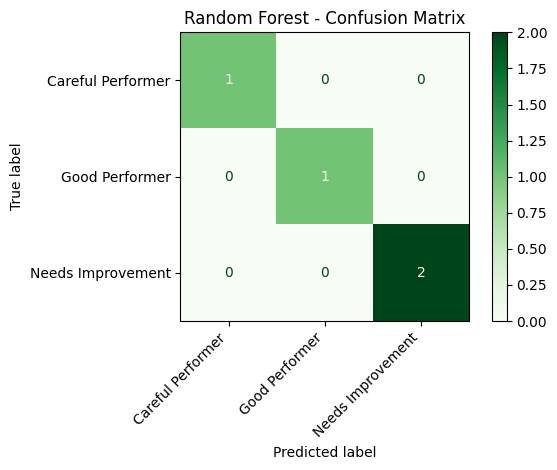

✅ Random Forest model trained and evaluated.


In [5]:
# Cell 5: Apply Random Forest Algorithm
# Purpose: Train and evaluate Random Forest classifier.

print("\n" + "="*60)
print("MODEL 1: RANDOM FOREST CLASSIFIER")
print("="*60)

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation: Classification report
print("\n📋 Random Forest - Classification Report:")
print(classification_report(
    y_test, y_pred_rf,
    target_names=label_encoder.classes_,
    zero_division=0
))

# Confusion Matrix Visualization
print("\n🖼️  Random Forest - Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(
    rf_model, X_test, y_test,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Greens
)
plt.xticks(rotation=45, ha='right')
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.savefig('Random_Forest_Confusion_Matrix.jpg', dpi=300)
plt.show()

print("✅ Random Forest model trained and evaluated.")


MODEL 2: XGBOOST CLASSIFIER


g:\code test\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:52:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📋 XGBoost - Classification Report:
                   precision    recall  f1-score   support

Careful Performer       1.00      1.00      1.00         1
   Good Performer       1.00      1.00      1.00         1
Needs Improvement       1.00      1.00      1.00         2

         accuracy                           1.00         4
        macro avg       1.00      1.00      1.00         4
     weighted avg       1.00      1.00      1.00         4


🖼️  XGBoost - Confusion Matrix:


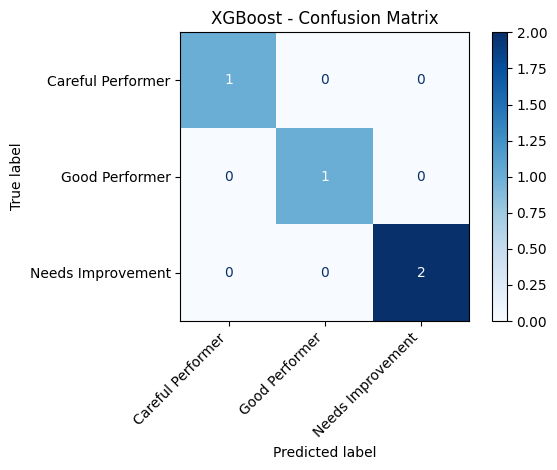

✅ XGBoost model trained and evaluated.


In [ ]:
# Cell 6: Apply XGBoost Algorithm
# Purpose: Train and evaluate XGBoost classifier.

print("\n" + "="*60)
print("MODEL 2: XGBOOST CLASSIFIER")
print("="*60)

# Initialize and train the model
# Disable default label encoder to avoid warnings with multi-class
# mlogloss for multi-class and its also called multi-log loss and cross-entropy loss

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss') 


xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation: Classification report
print("\n📋 XGBoost - Classification Report:")
print(classification_report(
    y_test, y_pred_xgb,
    target_names=label_encoder.classes_,
    zero_division=0
))

# Confusion Matrix Visualization
print("\n🖼️  XGBoost - Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(
    xgb_model, X_test, y_test,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Blues
)
plt.xticks(rotation=45, ha='right')
plt.title("XGBoost - Confusion Matrix")
plt.tight_layout()
plt.savefig('XGBoost_Confusion_Matrix.jpg', dpi=300)
plt.show()

print("✅ XGBoost model trained and evaluated.")


MODEL 3: NEURAL NETWORK (FEEDFORWARD)
🧩 Neural Network Architecture:


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)               │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91 (364.00 B)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4167 - loss: 6.9763
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4167 - loss: 6.1559  
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4167 - loss: 5.4649 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4167 - loss: 4.8544  
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4167 - loss: 4.3568 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4167 - loss: 3.9929  
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4167 - loss: 3.7345
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4167 - loss: 3.5292 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4167 - loss: 3.3233    
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4167 - loss: 3.1078     

📊 Making predictions on test set...

📋 Neural Network - Classification Report:
                   precision    recall  f1-score   support

Careful Per

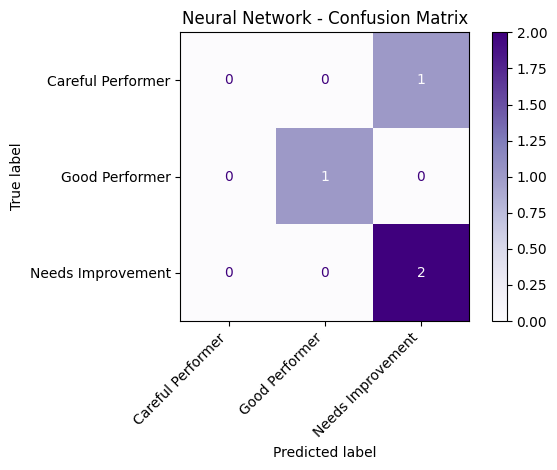


✅ Neural Network model training and evaluation completed.


In [44]:
# Cell 7: Neural Network Algorithm (Improved for Small Dataset)
# Purpose: Build, train, and evaluate a simple feedforward neural network.
# Note: With only 16 samples, deep learning is limited. This is for demonstration.
# Strategy: Use a very small network to avoid overfitting.

print("\n" + "="*60)
print("MODEL 3: NEURAL NETWORK (FEEDFORWARD)")
print("="*60)

# Get input dimensions dynamically
n_features = X_train.shape[1]    # Number of input features (e.g., 4)
n_classes = len(label_encoder.classes_)   # Number of output classes (e.g., 3)

# --- Build a very simple model to prevent overfitting ---
nn_model = Sequential([
    Input(shape=(n_features,)),  
    # Input layer: expects 4 features
    Dense(8, activation='relu'),          
    Dense(4, activation='relu'),          
    # Dense(16, activation='relu'),          
    # Dense(8, activation='relu'),          
    Dense(n_classes, activation='softmax')
])

# --- Compile the model ---
# Using standard settings for multi-class classification with integer labels
nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Correct for integer-encoded labels
    metrics=['accuracy']
)

# --- Display model summary ---
print("🧩 Neural Network Architecture:")
nn_model.summary()

# --- Train the model ---
history = nn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=2,           
    verbose=1,              
    shuffle=False           # for Avoiding shuffling due to very small data
)

# --- Make predictions ---
print("\n📊 Making predictions on test set...")
y_pred_nn_probs = nn_model.predict(X_test, verbose=0)
y_pred_nn = np.argmax(y_pred_nn_probs, axis=1)

# --- Evaluation: Classification Report ---
print("\n📋 Neural Network - Classification Report:")
print(classification_report(
    y_test,
    y_pred_nn,
    target_names=label_encoder.classes_,
    zero_division=0
))

# --- Confusion Matrix Visualization ---
print("\n🖼️  Neural Network - Confusion Matrix:")
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_nn,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Purples,
    colorbar=True
)
plt.title("Neural Network - Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save plot to file
try:
    plt.savefig('Neural_Network_Confusion_Matrix.jpg', dpi=300, bbox_inches='tight')
    print("✅ Confusion matrix saved as 'Neural_Network_Confusion_Matrix.jpg'")
except Exception as e:
    print(f"❌ Could not save image: {e}")

plt.show()

# --- Final note ---
print("\n✅ Neural Network model training and evaluation completed.")


STEP 8: COMPARING MODEL ACCURACIES

📊 Accuracy Scores:
            Model  Accuracy
0   Random Forest      1.00
1         XGBoost      1.00
2  Neural Network      0.75


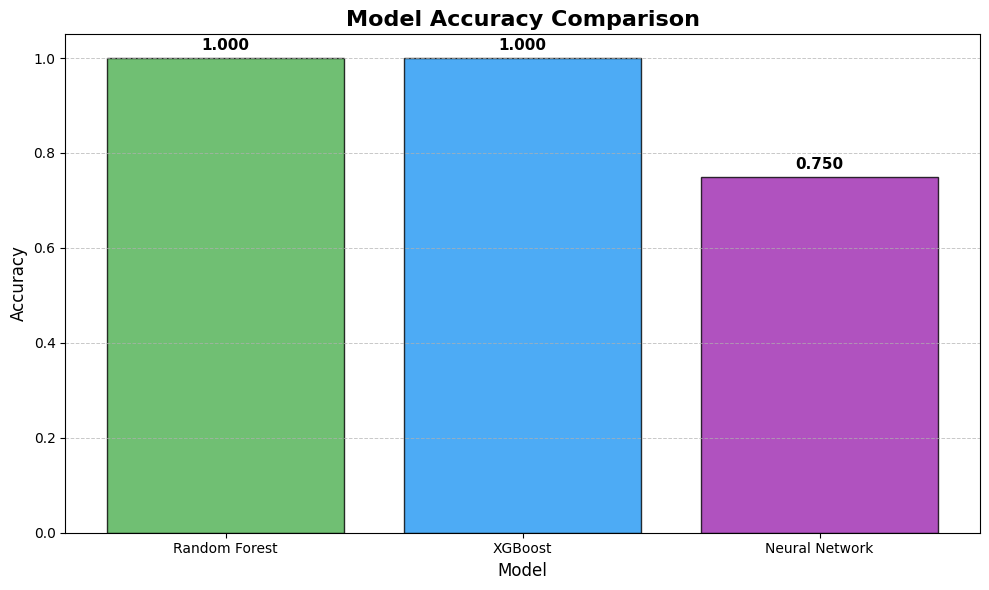


✅ Accuracy comparison completed. All models evaluated and plotted.


In [45]:
# Cell 8: Compare Model Accuracies with Bar Chart
# Purpose: Visualize and compare the accuracy of all three models.

print("\n" + "="*60)
print("STEP 8: COMPARING MODEL ACCURACIES")
print("="*60)

from sklearn.metrics import accuracy_score

# Calculate accuracy for each model
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
acc_nn = accuracy_score(y_test, y_pred_nn)

# Store results in a dictionary
model_names = ['Random Forest', 'XGBoost', 'Neural Network']
accuracies = [acc_rf, acc_xgb, acc_nn]

# Create a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

print("\n📊 Accuracy Scores:")
print(results_df.round(3))

# --- Bar Plot ---
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['Accuracy'], 
               color=['#4CAF50', '#2196F3', '#9C27B0'], 
               edgecolor='black', alpha=0.8)

# Add title and labels
plt.title("Model Accuracy Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.05)  # Accuracy ranges from 0 to 1

# Add value labels on top of each bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{acc:.3f}", ha='center', va='bottom', fontsize=11, fontweight='bold')

# Style the grid
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

print("\n✅ Accuracy comparison completed. All models evaluated and plotted.")